In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline

In [2]:
import inspect
import math
import os
import warnings

#import arviz as az

import jax.numpy as jnp
from jax import lax, ops, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation

# Linear Regression

Let's have two variables and 80 observations in training, and 20 in the test set

In [3]:
X = np.random.normal(0, 1, size=[100, 2])

In [10]:
y = 10*X[:, 0] - 4*X[:, 1] + np.random.normal(0, 1, size=100) + np.pi

In [11]:
X_train, X_test = X[:80,:], X[80:,:]
y_train, y_test = y[:80], y[80:]

## $\S$ 3.1: Making and training a model

In [24]:
def simple_linear_regression(X, y=None):
    """
    """
    coef0 = numpyro.sample("coef0", dist.Normal(0,6))
    coef1 = numpyro.sample("coef1", dist.Normal(0,6))
    intercept = numpyro.sample("b", dist.Normal(0,6))
    prediction = coef0*X[:,0] + coef1*X[:,1] + intercept
    std_err = numpyro.sample('sigma', dist.Exponential(1))
    return numpyro.sample("outcome", dist.Normal(prediction, std_err), obs=y)

In [25]:
chain_run = MCMC(NUTS(simple_linear_regression), num_warmup=500, num_samples=2500, num_chains=1)

In [26]:
chain_run.run(random.PRNGKey(0), X=X_train, y=y_train)

sample: 100%|██████████| 3000/3000 [00:05<00:00, 507.58it/s, 7 steps of size 7.29e-01. acc. prob=0.92]


In [30]:
# What do the in-sample predictions look like?
predictions = Predictive(simple_linear_regression, 
                         posterior_samples=chain_run.get_samples())(random.PRNGKey(2), X_train)['outcome']

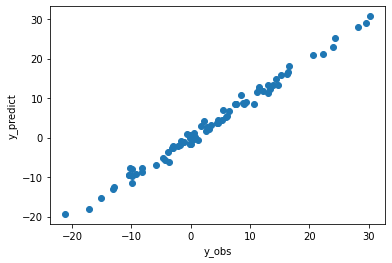

In [38]:
plt.plot(y_train, predictions.mean(axis=0), 'o')
plt.ylabel('y_predict')
plt.xlabel('y_obs');

In [39]:
chain_run.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      3.35      0.12      3.35      3.14      3.54   2420.60      1.00
     coef0      9.83      0.14      9.83      9.61     10.08   2619.28      1.00
     coef1     -4.20      0.12     -4.20     -4.38     -4.01   2595.48      1.00
     sigma      1.07      0.09      1.06      0.92      1.21   1847.60      1.00

Number of divergences: 0


## Predict over new values

The first naive attempt will fail, because the test and training sets are different sizes:

In [40]:
# What do the in-sample predictions look like?
predictions_test = Predictive(simple_linear_regression, 
                              posterior_samples=chain_run.get_samples())(random.PRNGKey(2), X_test)['outcome']

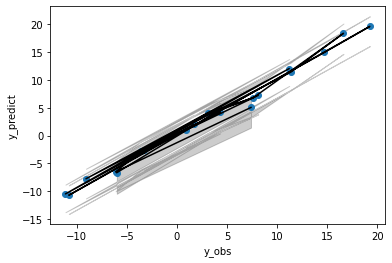

In [49]:
plt.plot(y_test, predictions_test.mean(axis=0), 'o')
plt.ylabel('y_predict')

y_mu = jnp.mean(predictions_test, 0)
y_ci = jnp.percentile(predictions_test, (0.05, 94.5), 0)

plt.plot(y_test, y_mu, "k", lw=1.5)
plt.fill_between(y_test, y_ci[0], y_ci[1], color="k", alpha=0.2)

plt.xlabel('y_obs');


## Generate values